In [61]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt

In [62]:
os.chdir("D:/dataset/COMP5703/ana")

In [63]:
data = pd.read_excel("data2.xlsx")

In [64]:
def extract_parts(pw):
    match = re.match(r"GRT(\d{4})([^_]+)_([^_]+)_([^_]+)", pw)
    if match:
        return match.groups()
    return [None, None, None, None]

In [65]:
data[['code_4digit', 'part1', 'part2', 'part3']] = data['password'].apply(lambda x: pd.Series(extract_parts(x)))
data['part2'] = data['part2'].str[4:]

In [66]:
part1_counts = data.groupby('peaksf')['part1'].value_counts().unstack(fill_value=0)

part2_counts = data.groupby('peaksf')['part2'].value_counts().unstack(fill_value=0)

part3_counts = data.groupby('peaksf')['part3'].value_counts().unstack(fill_value=0)


In [67]:
bl_df = data[data['part1'] == 'BL'][['code_4digit', 'peaksf']].rename(columns={'peaksf': 'peaksf_BL'})
week6_df = data[data['part1'] == '6week'][['code_4digit', 'peaksf']].rename(columns={'peaksf': 'peaksf_6week'})


merged_df = pd.merge(bl_df, week6_df, on='code_4digit', how='inner')

In [68]:
merged_df['diff'] = merged_df['peaksf_6week'] - merged_df['peaksf_BL']

diff_counts = merged_df['diff'].value_counts().sort_index()

diff_ratios = (diff_counts / diff_counts.sum()).round(4)

diff_summary = pd.DataFrame({
    'diff_value': diff_counts.index,
    'count': diff_counts.values,
    'ratio': diff_ratios.values
})


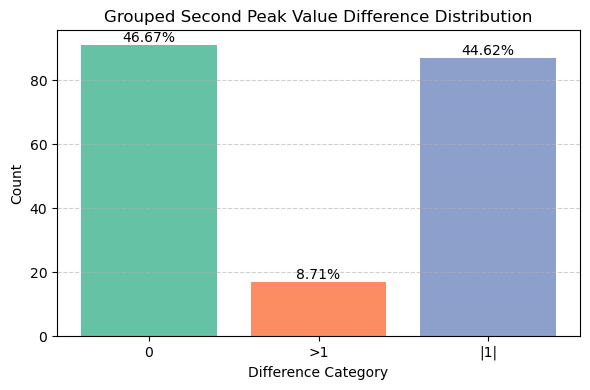

In [69]:
def classify_diff(val):
    if val == 0:
        return '0'
    elif abs(val) == 1:
        return '|1|'
    else:
        return '>1'

# 添加分类列
diff_summary['category'] = diff_summary['diff_value'].apply(classify_diff)

# 汇总每类 count 与 ratio
grouped = diff_summary.groupby('category').agg({'count': 'sum', 'ratio': 'sum'}).reset_index()

# 画柱状图
ig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(grouped['category'], grouped['count'], color=['#66c2a5', '#fc8d62', '#8da0cb'])


# 添加文本：比例
for bar, ratio in zip(bars, grouped['ratio']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{ratio:.2%}',
             ha='center', va='bottom', fontsize=10)

# 图表设置
plt.xlabel('Difference Category')
plt.ylabel('Count')
plt.title('Grouped Second Peak Value Difference Distribution')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

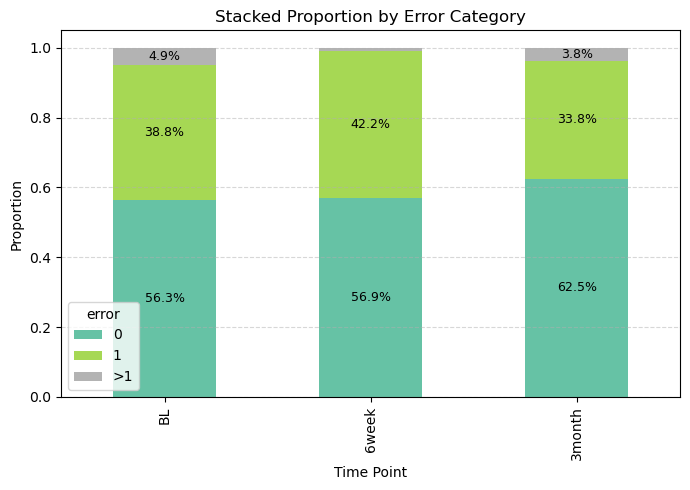

In [70]:
# 将图例标题从 part1 改为 error
def group_label(val):
    if val == 0:
        return '0'
    elif val == 1:
        return '1'
    else:
        return '>1'

# 添加分类列
part1_counts['group'] = part1_counts.index.map(group_label)

# 聚合每类在不同时间点的总数量
grouped_counts = part1_counts.groupby('group')[['BL', '6week', '3month']].sum()

# 转置以便绘图（行：时间点，列：误差类别）
grouped_counts = grouped_counts.T

# 计算每行的比例
proportions = grouped_counts.div(grouped_counts.sum(axis=1), axis=0)

# 确保索引是字符串，避免绘图出错
proportions.index = ['BL', '6week', '3month']
fig, ax = plt.subplots(figsize=(7, 5))
proportions.plot(kind='bar', stacked=True, colormap='Set2', ax=ax)

# 添加百分比标签
for i, row in enumerate(proportions.values):
    cum_height = 0
    for j, height in enumerate(row):
        if height > 0.01:
            ax.text(i, cum_height + height / 2, f'{height:.1%}', ha='center', va='center', fontsize=9)
        cum_height += height

ax.set_ylabel('Proportion')
ax.set_xlabel('Time Point')
ax.set_title('Stacked Proportion by Error Category')
ax.legend(title='error')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


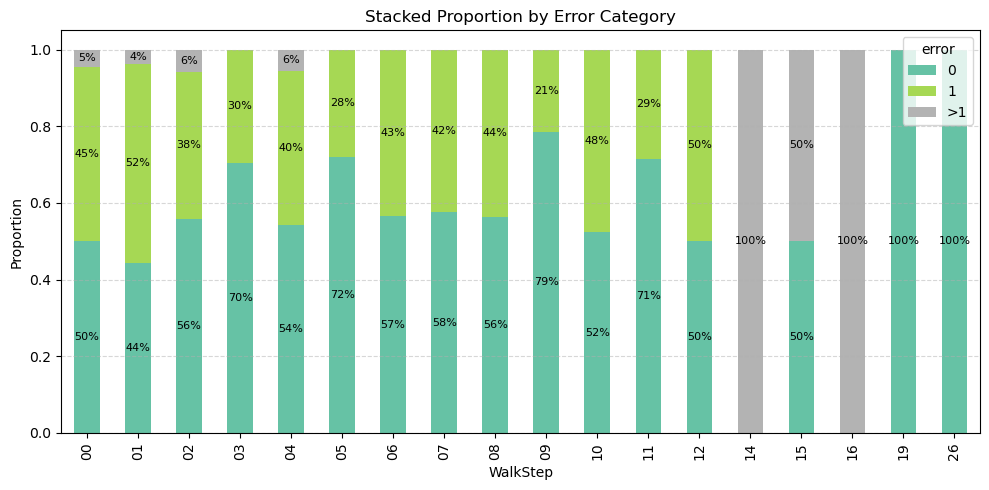

In [71]:
columns = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '14', '15', '16', '19', '26']
part2_counts.columns = ['00'] + columns[0:]

# 添加 error 分类列
def classify_error(val):
    if val == 0:
        return '0'
    elif val == 1:
        return '1'
    else:
        return '>1'

part2_counts['error'] = part2_counts.index.map(classify_error)

# 按 error 分组求和
grouped = part2_counts.groupby('error').sum()

# 转置并计算比例
grouped_T = grouped.T
proportions = grouped_T.div(grouped_T.sum(axis=1), axis=0)

# 删除所有为0的列（没有任何数据的 error 类别）
proportions = proportions.loc[:, (grouped_T.sum(axis=0) > 0)]

# 绘图
fig, ax = plt.subplots(figsize=(10, 5))
proportions.plot(kind='bar', stacked=True, colormap='Set2', ax=ax)

# 添加百分比标签
for i, row in enumerate(proportions.values):
    cum_height = 0
    for j, height in enumerate(row):
        if height > 0.01:
            ax.text(i, cum_height + height / 2, f'{height:.0%}', ha='center', va='center', fontsize=8)
        cum_height += height

# 图表设置
ax.set_ylabel('Proportion')
ax.set_xlabel('WalkStep')
ax.set_title('Stacked Proportion by Error Category')
ax.legend(title='error')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

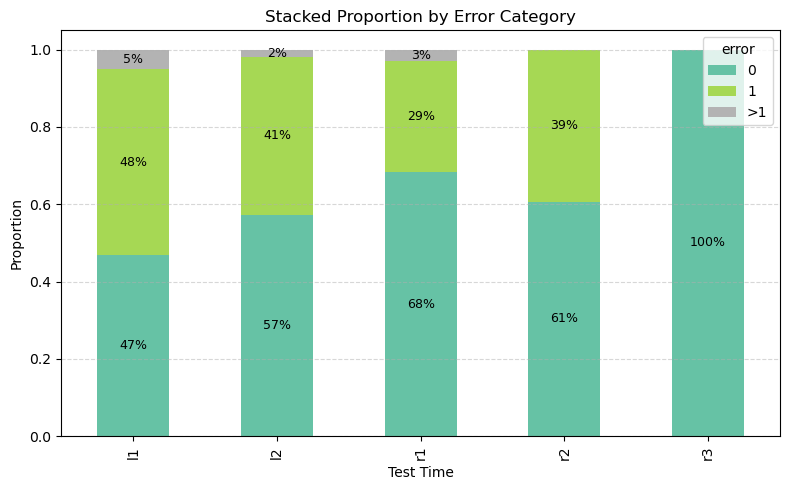

In [72]:
def classify_error(val):
    if val == 0:
        return '0'
    elif val == 1:
        return '1'
    else:
        return '>1'

part3_counts['error'] = part3_counts.index.map(classify_error)

# 3. 按 error 聚合并求和
grouped = part3_counts.groupby('error').sum()

# 4. 转置并计算每列比例
grouped_T = grouped.T
proportions = grouped_T.div(grouped_T.sum(axis=1), axis=0)

# 5. 删除所有值为 0 的 error 类别（无数据的列）
proportions = proportions.loc[:, (grouped_T.sum(axis=0) > 0)]

# 6. 绘图
fig, ax = plt.subplots(figsize=(8, 5))
proportions.plot(kind='bar', stacked=True, colormap='Set2', ax=ax)

# 7. 添加百分比文字标签
for i, row in enumerate(proportions.values):
    cum_height = 0
    for j, height in enumerate(row):
        if height > 0.01:
            ax.text(i, cum_height + height / 2, f'{height:.0%}', ha='center', va='center', fontsize=9)
        cum_height += height

# 8. 图表美化设置
ax.set_ylabel('Proportion')
ax.set_xlabel('Test Time')
ax.set_title('Stacked Proportion by Error Category')
ax.legend(title='error')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

KeyError: 'category'

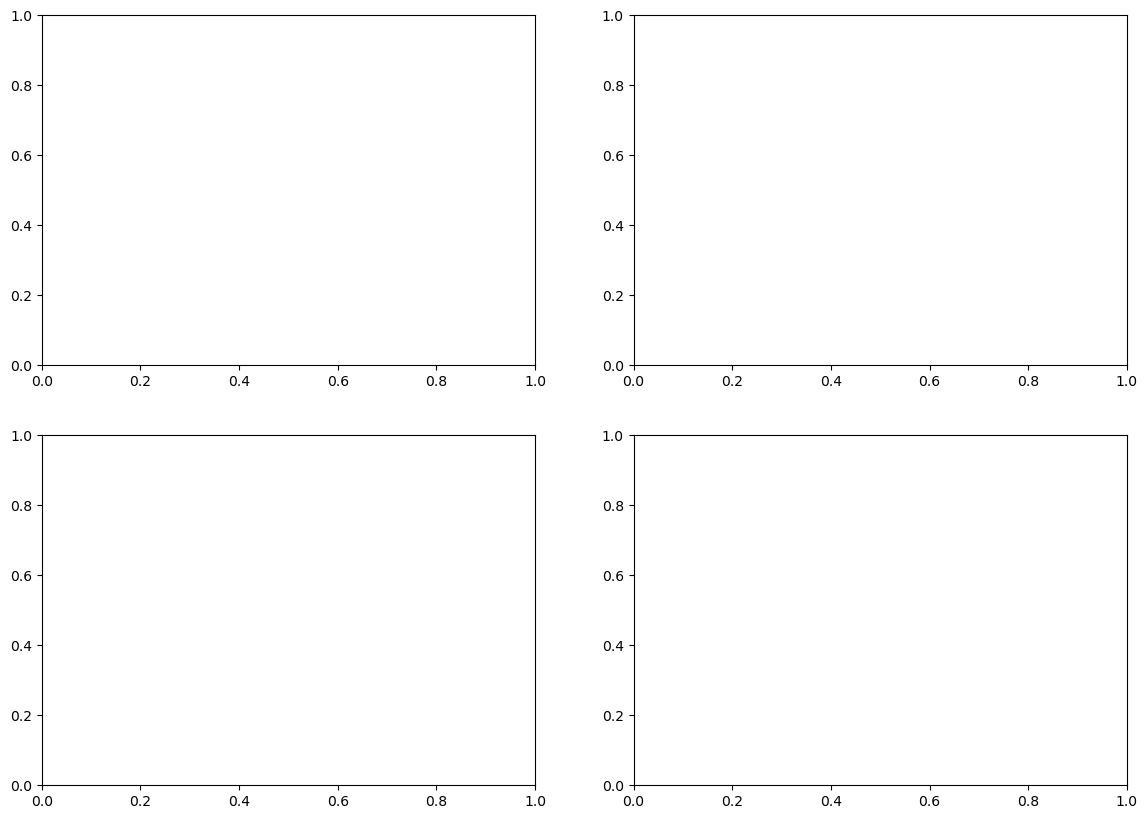

In [73]:
import matplotlib.pyplot as plt

# 创建一个2行2列的画板
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

### 图1：差值类别的柱状图 ###
bars = axs[0].bar(grouped['category'], grouped['count'], color=['#66c2a5', '#fc8d62', '#8da0cb'])
for bar, ratio in zip(bars, grouped['ratio']):
    axs[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{ratio:.2%}',
                ha='center', va='bottom', fontsize=10)
axs[0].set_xlabel('Difference Category')
axs[0].set_ylabel('Count')
axs[0].set_title('Grouped Second Peak Value Difference Distribution')
axs[0].grid(axis='y', linestyle='--', alpha=0.6)

### 图2：part1 按误差类别的堆叠图 ###
proportions1 = part1_counts.groupby(part1_counts.index.map(group_label))[['BL', '6week', '3month']].sum().T
proportions1 = proportions1.div(proportions1.sum(axis=1), axis=0)
proportions1.plot(kind='bar', stacked=True, colormap='Set2', ax=axs[1])
axs[1].set_xticklabels(proportions1.index, rotation=0)  # 横向显示X轴标签
for i, row in enumerate(proportions1.values):
    cum_height = 0
    for j, height in enumerate(row):
        if height > 0.01:
            axs[1].text(i, cum_height + height / 2, f'{height:.1%}', ha='center', va='center', fontsize=9)
        cum_height += height
axs[1].set_ylabel('Proportion')
axs[1].set_xlabel('Time Point')
axs[1].set_title('Stacked Proportion by Error Category (Part1)')
axs[1].legend(title='error')
axs[1].grid(axis='y', linestyle='--', alpha=0.5)

### 图3：part2 步长对应误差堆叠图 ###
grouped_T2 = part2_counts.groupby('error').sum().T
proportions2 = grouped_T2.div(grouped_T2.sum(axis=1), axis=0)
proportions2 = proportions2.loc[:, (grouped_T2.sum(axis=0) > 0)]
proportions2.plot(kind='bar', stacked=True, colormap='Set2', ax=axs[2])
axs[2].set_xticklabels(proportions2.index, rotation=0)  # 横向显示X轴标签
for i, row in enumerate(proportions2.values):
    cum_height = 0
    for j, height in enumerate(row):
        if height > 0.01:
            axs[2].text(i, cum_height + height / 2, f'{height:.0%}', ha='center', va='center', fontsize=8)
        cum_height += height
axs[2].set_ylabel('Proportion')
axs[2].set_xlabel('WalkStep')
axs[2].set_title('Stacked Proportion by Error Category (Part2)')
axs[2].legend(title='error')
axs[2].grid(axis='y', linestyle='--', alpha=0.5)

### 图4：part3 测试时间对应误差堆叠图 ###
grouped_T3 = part3_counts.groupby('error').sum().T
proportions3 = grouped_T3.div(grouped_T3.sum(axis=1), axis=0)
proportions3 = proportions3.loc[:, (grouped_T3.sum(axis=0) > 0)]
proportions3.plot(kind='bar', stacked=True, colormap='Set2', ax=axs[3])
axs[3].set_xticklabels(proportions3.index, rotation=0)  # 横向显示X轴标签
for i, row in enumerate(proportions3.values):
    cum_height = 0
    for j, height in enumerate(row):
        if height > 0.01:
            axs[3].text(i, cum_height + height / 2, f'{height:.0%}', ha='center', va='center', fontsize=9)
        cum_height += height
axs[3].set_ylabel('Proportion')
axs[3].set_xlabel('Test Time')
axs[3].set_title('Stacked Proportion by Error Category (Part3)')
axs[3].legend(title='error')
axs[3].grid(axis='y', linestyle='--', alpha=0.5)

# 整体布局调整
plt.tight_layout()
plt.show()
